In [1]:
# google mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [5]:
import cv2
import numpy as np
import torch
import glob
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
from google.colab.patches import cv2_imshow

%matplotlib inline

from utils.openpose_net import OpenPoseNet

# Test Image
- Preprocessing 
- image -> np.array -> tensor

In [4]:
# load network
net = OpenPoseNet()

# read pretrained parameters
net_weights = torch.load('/content/drive/MyDrive/weights/pose_model_scratch.pth',
                         map_location={'cuda:0':'cpu'})
keys = list(net_weights.keys())

weights_load = {}

# copy loaded parameters into net.state_dict().keys() in net.
for i in range(len(keys)):
  weights_load[list(net.state_dict().keys())[i]] = net_weights[list(keys)[i]]

# weights into model 
state = net.state_dict()
state.update(weights_load)
net.load_state_dict(state)

print("Success in setting a network: pretrained weights were loaded")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Success in setting a network: pretrained weights were loaded


In [18]:
# set image size 
size = (368, 368)

# read test images
test_dir = glob.glob('/content/drive/MyDrive/data/patient_images/*.jpg')

# color standardization 
color_mean = [0.485, 0.456, 0.406]
color_std = [0.229, 0.224, 0.225]

def preprocess(img_dir):
  # read image
  img = cv2.imread(img_dir)
  # resize image -> (368,368,3)
  resize_img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)
  # preprocessing image
  img = resize_img.astype(np.float32) / 255.
  # BGR to RGB
  prep_img = img.copy()[:,:, ::-1] 
  # color standardization
  for i in range(3):
    prep_img[:,:,i] = (prep_img[:,:,i] - color_mean[i]) / color_std[i]

  # cv2_imshow(prep_img*255)
  # (height, width, channel) -> (channel, height, widht)
  img = prep_img.transpose((2,0,1)).astype(np.float32)

  return img, resize_img

In [19]:
X, Y = [], []

for img_dir in test_dir: 
  img, org = preprocess(img_dir)
  X.append(img)
  Y.append(org)

In [20]:
X = np.array(X)
Y = np.array(Y)
X.shape

(19, 3, 368, 368)

In [21]:
# array to tensor
X = torch.from_numpy(X) # (3, 368, 368)
X.shape

torch.Size([19, 3, 368, 368])

# Obtain confidence heatmap and PAFs from OpenPose

In [16]:
net.eval()
pred, _ = net(X)

In [17]:
pred[0].shape # PAFs

torch.Size([19, 38, 46, 46])

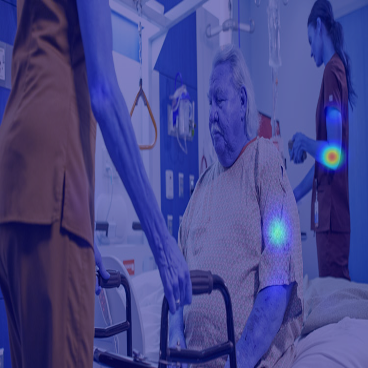

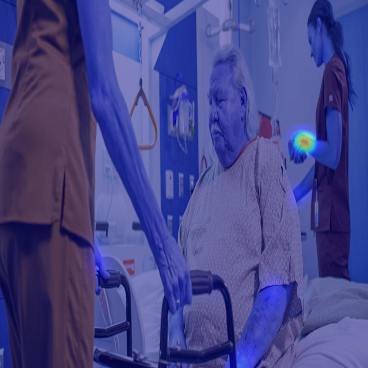

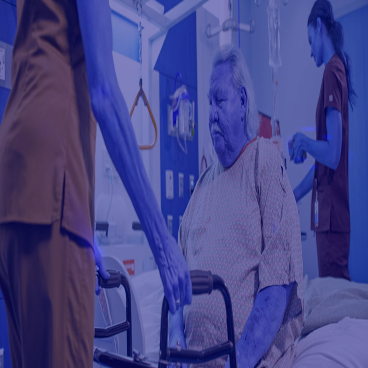

In [22]:
# tensor -> np.array
pafs = pred[0][0].detach().numpy().transpose(1,2,0) #(ch, h, w) -> (h,w,ch)
heatmaps = pred[1][0].detach().numpy().transpose(1,2,0)

pafs = cv2.resize(pafs, size, interpolation = cv2.INTER_CUBIC)
heatmaps = cv2.resize(heatmaps, size, interpolation = cv2.INTER_CUBIC)

conf = heatmaps[:,:,6] # 6 represents left elbow
conf = Image.fromarray(np.uint8(cm.jet(conf)*255))
conf = np.asarray(conf.convert("RGB"))

# blending image
blend = cv2.addWeighted(Y[0], 0.5, conf, 0.5, 0)
blend = cv2.cvtColor(blend, cv2.COLOR_RGB2BGR)
cv2_imshow(blend)

# left wrist
heat_map = heatmaps[:, :, 7]  # 7: left wrist
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))

# bledning 
blend = cv2.addWeighted(Y[0], 0.5, heat_map, 0.5, 0)
blend = cv2.cvtColor(blend, cv2.COLOR_RGB2BGR)
cv2_imshow(blend)


# PAF vector b/w left elbow and left wrist : 24
paf = pafs[:, :, 24] 
paf = Image.fromarray(np.uint8(cm.jet(paf)*255))
paf = np.asarray(paf.convert('RGB'))

# blending
blend = cv2.addWeighted(Y[0], 0.5, paf, 0.5, 0)
blend = cv2.cvtColor(blend, cv2.COLOR_RGB2BGR)
cv2_imshow(blend)

# decode
- find link b/w body parts
- draw skeleton on original image
- input: confidence heatmap and PAFs
- output: skeleton image
- directory: ./utils/decode_pose.py

In [23]:
from utils.decode_pose import decode_pose

In [25]:
pafs, heatmaps = pred[0], pred[1] 

result = []
for i in range(len(pafs)):
  # tensor -> np.array
  paf = pafs[i].detach().numpy().transpose(1,2,0) # (ch, h, w) -> (h,w,ch)
  heatmap = heatmaps[i].detach().numpy().transpose(1,2,0) # (ch, h, w) -> (h,w,ch)

  # resize image (46,46) -> (368,368)
  paf = cv2.resize(paf, size, interpolation = cv2.INTER_CUBIC)
  heatmap = cv2.resize(heatmap, size, interpolation = cv2.INTER_CUBIC)
  # load original image
  resize_img = cv2.cvtColor(Y[i], cv2.COLOR_BGR2RGB)
  _, pose, _, _ = decode_pose(resize_img, heatmap, paf)

  result.append(pose)

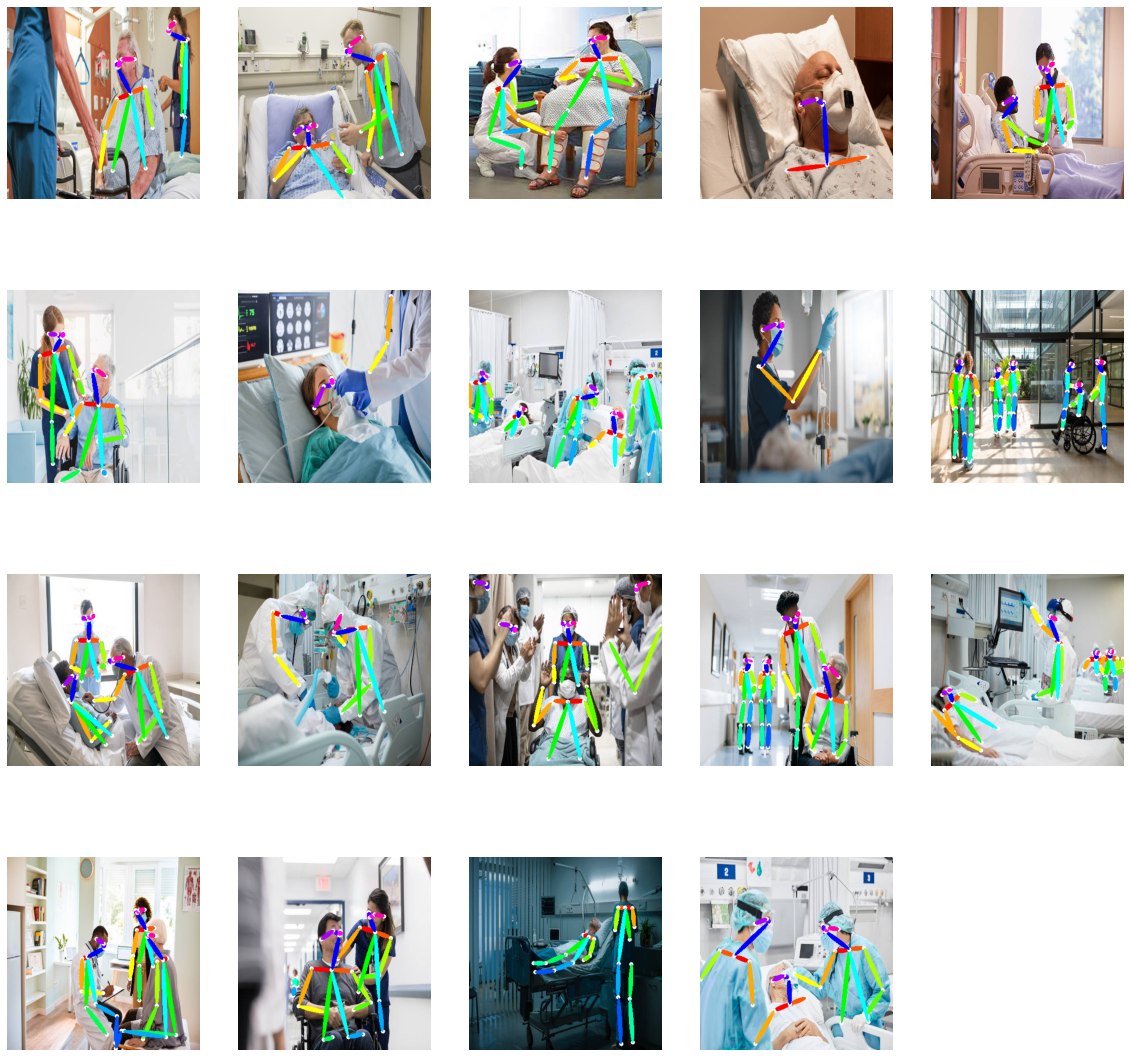

In [28]:
# draw the result image

# create figure
fig = plt.figure(figsize=(20, 20))
  
# setting values to rows and column variables
rows = 4
columns = 5

for i in range(19):
  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, i+1)
  # showing image
  plt.imshow(result[i])
  plt.axis('off')

plt.savefig("/content/drive/MyDrive/result.png")
plt.show()